# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откроем и изучим файл

Импортируем все необходимые библиотеки.

In [1]:
# все что потребуется импортитроватть в процессе работы складываем тут
import pandas as pd 
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore') # чтобы было красивее и не пугали предупреждения

In [2]:
data = pd.read_csv('/datasets/users_behavior.csv')

In [3]:
data

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


Описание данных
Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Хоть по условию и сказано, что предобработка уже сделана, но очень режет глаза количество звонков и смс типа float.

In [5]:
data[['calls', 'messages']] = data[['calls', 'messages']].astype(int) # сменим тип данных на int

Посмотрим на целевой показатель.

In [6]:
data['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

Классы несбалансированы. Соотношение ~2:1.

In [7]:
data.duplicated().sum()

0

In [8]:
data.isna().sum()/len(data)*100

calls       0.0
minutes     0.0
messages    0.0
mb_used     0.0
is_ultra    0.0
dtype: float64

In [27]:
data['is_ultra'].unique()

array([0, 1])

In [26]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


Итак:
- данные чистые, без пропусков
- нет высокого показателя корреляции с целевым признаком
Нам предстоит решить задачу классификации, а точнее бинарной классификации, так как целевой признак имеет два значения (0, 1).


## Разбейте данные на выборки

Теперь мы разделим набор данных на тренировочные(обучающие) и тестовые. Обучающие данные - это данные, на которых модель будет учиться. Тестовые данные - это данные, которые мы будем использовать, чтобы увидеть, насколько хорошо модель работает с невидимыми данными. 

In [9]:
features = data.drop(['is_ultra'], axis=1)
target = data['is_ultra']

In [10]:
# разобьем сет на выборки (обучающую и тестовую)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.3, random_state=123, stratify=target) 
# отделим от тестовой выборки валидационную
features_valid, features_test, target_valid, target_test = train_test_split(
    features_test, target_test, test_size=0.5, random_state=123, stratify=target_test)

*stratify=target, возвращает стратифицированные складки: каждый набор содержит примерно такой же процент выборок каждого целевого класса, как и полный набор.*

Посмотрим на результат разделения

In [11]:
print('Размерность набора данных features_train: ', features_train.shape)
print('Размерность набора данных target_train: ', target_train.shape)
#print('Размерность набора данных features_valid: ', features_valid.shape)
#print('Размерность набора данных target_valid: ', target_valid.shape)
print('Размерность набора данных features_test: ', features_test.shape)
print('Размерность набора данных target_test: ', target_test.shape)

Размерность набора данных features_train:  (2249, 4)
Размерность набора данных target_train:  (2249,)
Размерность набора данных features_test:  (483, 4)
Размерность набора данных target_test:  (483,)


In [12]:
target_train.value_counts(), target_valid.value_counts(), target_test.value_counts()

(0    1560
 1     689
 Name: is_ultra, dtype: int64,
 0    334
 1    148
 Name: is_ultra, dtype: int64,
 0    335
 1    148
 Name: is_ultra, dtype: int64)

Соотношение классов сохранилось, однако данные несбалансированы, необходимо это помнить при обучении моделей.

## Исследуем модели

Далее мы должны построить наши модели. У каждой модели, которую мы строим, есть набор гиперпараметров, которые мы можем настроить. Настройка параметров - это когда вы проходите через процесс, чтобы найти оптимальные параметры для вашей модели для повышения точности.При создании моделей будем пользоваться методом GridSearchCV. Перекрестная проверка - это когда набор данных случайным образом разбивается на группы «k». Одна из групп используется в качестве тестового набора, а остальные используются в качестве тренировочного набора Модель обучается на тренировочном наборе и оценивается на тестовом наборе. Затем процесс повторяется до тех пор, пока каждая уникальная группа не будет использоваться в качестве тестового набора.

### k-Ближайшие соседи (k-NN)

Первая модель, которую мы построим, это k-Nearest Neighbours (k-NN). Модели k-NN работают, беря точку данных и глядя на «k» ближайших помеченных точек данных. Затем точке данных присваивается метка для большинства ближайших точек «k».

In [13]:
knn = KNeighborsClassifier()
params_knn = {
    'n_neighbors': np.arange(1, 31), 
    'weights': ('uniform', 'distance'), 
    'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute') 
}
knn_gs = GridSearchCV(knn, params_knn, cv=5)
knn_gs.fit(features_train, target_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute'),
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
                         'weights': ('uniform', 'distance')})

Зададим переменную для классификатора k-NN. Затем нам нужно создать словарь для хранения всех значений, которые мы будем тестировать для «n_neighbors», что является гиперпараметром. 

- n_neighbors - принимает целое значение, по умолчанию = 5
Количество соседей, используемых по умолчанию для kneighborsзапросов.
- weights {'uniform', 'distance'} по умолчанию = 'uniform'
    Весовая функция, используемая в прогнозировании. Возможные значения:
        - uniform : однородные веса. Все точки в каждой окрестности имеют одинаковый вес.
        - distance : взвешивание точек обратно их расстоянию. в этом случае более близкие соседи точки запроса будут иметь большее влияние, чем соседи, которые находятся дальше.
- algorithm{'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'
        - Алгоритм, используемый для вычисления ближайших соседей.


В нашем случае мы используем 5-кратную перекрестную проверку. Набор данных разбит на 5 групп, и модель обучается и тестируется 5 раз, чтобы у каждой группы был шанс стать тестовым набором. Вот как мы будем оценивать нашу модель, работающую с каждым значением гиперпараметра, чтобы увидеть, какое значение для 'n_neighbors' дает нам лучший результат.

Сохраним нашу лучшую модель k-NN в «knn_best», используя функцию «best_estimator_».

In [14]:
#save best model
knn_best = knn_gs.best_estimator_
knn_pred = knn_gs.predict(features_valid)
accuracy = accuracy_score(target_valid, knn_pred)
print("Accuracy лучшей модели на валидационной выборке:", accuracy)
print('Лучший результат у модели при параметрах', knn_gs.best_params_) 

Accuracy лучшей модели на валидационной выборке: 0.7655601659751037
Лучший результат у модели при параметрах {'algorithm': 'auto', 'n_neighbors': 13, 'weights': 'uniform'}


### Случайный Лес (RandomForestClassifier)
Следующая модель, которую мы построим, - это случайный лес. Случайный лес сам по себе считается моделью ансамбля, поскольку он представляет собой совокупность деревьев решений, объединенных для создания более точной модели.

In [15]:
rf = RandomForestClassifier(random_state=12345)
params_rf = {'n_estimators': [10, 20, 30, 40, 50], 'criterion': ('gini', 'entropy', 'log_loss'),'max_depth': range (1, 10, 1)}
rf_gs = GridSearchCV(rf, params_rf, cv=5)
rf_gs.fit(features_train, target_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=12345),
             param_grid={'criterion': ('gini', 'entropy', 'log_loss'),
                         'max_depth': range(1, 10),
                         'n_estimators': [10, 20, 30, 40, 50]})

Установим гиперпараметры, которые мы хотим настроить. 
    - N_estimators - количество деревьев в нашем случайном лесу. 
    - criterion{'gini', 'entropy', 'log_loss'}, default='gini' - Функция измерения качества разделения. Поддерживаемые критерии: «gini» для примеси Джини, «log_loss» и «entropy» для прироста информации Шеннона.
    - max_depth целое, default = None Максимальная глубина дерева. Если None, то узлы расширяются до тех пор, пока все листья не станут чистыми или пока все листья не будут содержать выборок меньше, чем min_samples_split.

Как и раньше, мы сохраним нашу лучшую модель и посмотрим ее параметры.

In [16]:
#сохраним лучшую модель
rf_best = rf_gs.best_estimator_
accuracy = rf_gs.score(features_valid, target_valid)
print("Accuracy лучшей модели на валидационной выборке:", accuracy)
print('Лучший результат у модели при параметрах', rf_gs.best_params_) 

Accuracy лучшей модели на валидационной выборке: 0.7883817427385892
Лучший результат у модели при параметрах {'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 40}


### Логистическая регрессия (LogisticRegression)
Наша последняя модель - логистическая регрессия. Несмотря на то, что в названии присутствует «регрессия», логистическая регрессия является методом классификации.

In [17]:
log_reg = LogisticRegression()
params_log_reg = {
    'max_iter': [20, 50, 100, 200, 500, 1000], 
    'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'), 
    'class_weight': ('balanced', 'None')
} 
rf_gs = GridSearchCV(log_reg, params_log_reg, cv=5)
log_reg.fit(features_train, target_train)

LogisticRegression()

In [18]:
accuracy = log_reg.score(features_valid, target_valid)
print("Accuracy модели на валидационной выборке:", accuracy) 
predict= log_reg.predict(features_valid)
print(classification_report(target_valid, predict))

Accuracy модели на валидационной выборке: 0.6991701244813278
              precision    recall  f1-score   support

           0       0.70      1.00      0.82       334
           1       1.00      0.02      0.04       148

    accuracy                           0.70       482
   macro avg       0.85      0.51      0.43       482
weighted avg       0.79      0.70      0.58       482



Модель плохо предсказывает пользователей тарифа Ультра (1)

In [19]:
print(f'knn: {knn_best.score(features_valid, target_valid)}')
print(f'rf: {rf_best.score(features_valid, target_valid)}')
print(f'log_reg: {log_reg.score(features_valid, target_valid)}')

knn: 0.7655601659751037
rf: 0.7883817427385892
log_reg: 0.6991701244813278


### Классификатор голосования(VotingClassifier)
Попробуем создать ансабль из ранее обученных моделей.

In [20]:
estimators=[('knn', knn_best), ('rf', rf_best), ('log_reg', log_reg)]#создаем классификатор, указываем модели
ensemble1 = VotingClassifier(estimators, voting='hard')
ensemble2 = VotingClassifier(estimators, voting='soft')

In [21]:
ensemble1.fit(features_train, target_train)
ensemble1.score(features_valid, target_valid)

0.7697095435684648

In [22]:
ensemble2.fit(features_train, target_train)
ensemble2.score(features_valid, target_valid)

0.7842323651452282

Если «жесткий», использует предсказанные метки классов для голосования по правилу большинства. В противном случае, если «мягкий», предсказывает метку класса на основе argmax сумм предсказанных вероятностей, что рекомендуется для ансамбля хорошо откалиброванных классификаторов.
Наша модель голосования ensemble2 показала схожий результат с RandomForestClassifier.

Вывод
Мы выбрали и обучили три разных модели:

k-Ближайшие соседи (k-NN)
Случайный Лес (RandomForestClassifier)
Логистическая регрессия (LogisticRegression)

Сделали ансамбль из наших моделей:

Классификатор голосования(VotingClassifier)

Лучший результат: RandomForestClassifier  Accuracy на валидационной выборке: 0.788.

Хуже всего справилась: LogisticRegression Accuracy хуже остальных моделей: 0.699.

VotingClassifier Показал результат схожий с лучшей моделью Accuracy: 0.784.

## Проверьте модель на тестовой выборке

Теперь давайте проверим оценки точности всех трех наших моделей на наших тестовых данных.

In [23]:
knn_predictions = knn_best.predict(features_test)
rf_predictions = rf_best.predict(features_test)
log_reg_predictions = log_reg.predict(features_test)
ensemble2_predictions = ensemble2.predict(features_test)
print(f'Accuracy knn: {knn_best.score(features_test, target_test)}')
print(f'Accuracy rf: {rf_best.score(features_test, target_test)}')
print(f'Accuracy log_reg: {log_reg.score(features_test, target_test)}')
print(f'Accuracy ensemble2: {ensemble2.score(features_test, target_test)}')

Accuracy knn: 0.7660455486542443
Accuracy rf: 0.8240165631469979
Accuracy log_reg: 0.7060041407867494
Accuracy ensemble2: 0.7971014492753623


Лучший результат RandomForestClassifier.

## (бонус) Проверьте модели на адекватность

Для сравнения проверим несколько моделей.

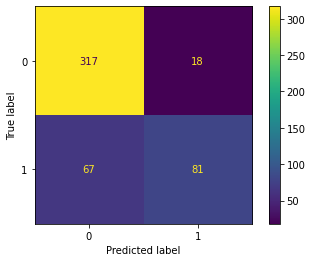

In [24]:
pred=pd.DataFrame(rf_predictions)
real=pd.DataFrame(target_test).reset_index().drop(['index'], axis=1)
matrix=confusion_matrix(real, pred)
disp = ConfusionMatrixDisplay(matrix)
disp.plot()

In [28]:
pd.DataFrame(precision_recall_fscore_support(real, pred))

,0,1
0,0.825521,0.818182
1,0.946269,0.547297
2,0.881780,0.655870
3,335.000000,148.000000


Точность предсказания тарифа 0 - 94%
Точность предсказания тарифа 1 -54%

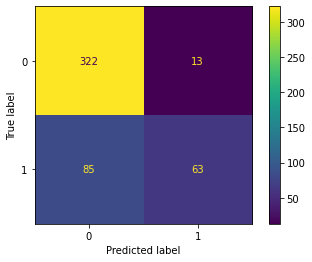

In [29]:
pred2=pd.DataFrame(ensemble2_predictions)
real2=pd.DataFrame(target_test).reset_index().drop(['index'], axis=1)
matrix=confusion_matrix(real2, pred2)
disp = ConfusionMatrixDisplay(matrix)
disp.plot()

In [30]:
pd.DataFrame(precision_recall_fscore_support(real2, pred2))

,0,1
0,0.791155,0.828947
1,0.961194,0.425676
2,0.867925,0.562500
3,335.000000,148.000000


Точность предсказания тарифа 0 - 96%
Точность предсказания тарифа 1 - 42%

Наши модели не справляется с определением пользователей тарифа «Ультра» — 1, лес деревьев решений справляется чуть лучше.Пользователи тарифа 0 - «Смарт» определяются с хорошей точностью.

Общий вывод

Предоставленные данные чистые одняко несбаллансированы, необходимы дополнительные данные по опльзователям тарифа "Ультра"

Мы построили четыре модели  k-NN, RandomForestClassifier, Logistic Regression и VotingClassifier;
Наиболее точные результаты показала модель RandomForestClassifier с параметрами {'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 40}  и Accuracy 0.824 на тестовых данных.
